In [1]:
import json
import gzip
import pandas as pd

source_file = '/Users/dsuveges/project/evidences/updated_eva/cttv012-20200928-test2.json.gz'

parsed_data = []

with gzip.open(source_file) as f:
    for line in f:
        data = json.loads(line)
        evidence = {
            'type': data['type'],
            'target': data['unique_association_fields']['gene'],
            'disease': data['unique_association_fields']['phenotype'].split('/')[-1],
            'rsid': data['unique_association_fields']['variant_id'],
            'clinvar_acces': data['unique_association_fields']['clinvarAccession'],   
        }
        
        if data['type'] == 'genetic_association':
            evidence.update({
                'score': data['evidence']['variant2disease']['resource_score']['value'],
                'star': data['evidence']['variant2disease']['clinvar_rating']['star_rating'],
                'clinical_significance': data['evidence']['variant2disease']['clinical_significance'],
                'so_code':  data['evidence']['gene2variant']['functional_consequence'].split('/')[-1],
            })
            
        elif data['type'] == 'somatic_mutation':
            evidence.update({
                'score': data['evidence']['resource_score']['value'],
                'star': data['evidence']['clinvar_rating']['star_rating'],
                'review_status': data['evidence']['clinvar_rating']['review_status'],
                'clinical_significance': data['evidence']['clinical_significance'],
                'so_code':  data['evidence']['known_mutations'][0]['functional_consequence'].split('/')[-1],
            })
        parsed_data.append(evidence)

eva_df = pd.DataFrame(parsed_data)
print(len(eva_df))
print(eva_df.head())

574097
                  type           target        disease          rsid  \
0  genetic_association  ENSG00000154803  Orphanet_2903   rs886037610   
1  genetic_association  ENSG00000186832  Orphanet_2337  rs1555573633   
2  genetic_association  ENSG00000103197   Orphanet_805   rs137854012   
3  genetic_association  ENSG00000103197   Orphanet_805   rs137854420   
4  genetic_association  ENSG00000103197   Orphanet_805   rs137854007   

  clinvar_acces         score  star                   review_status  \
0  RCV000003542  1.000000e-07     0  no assertion criteria provided   
1  RCV000015714  1.000000e-07     0  no assertion criteria provided   
2  RCV000042664  1.000000e-07     0           no assertion provided   
3  RCV000042684  1.000000e-07     0           no assertion provided   
4  RCV000042927  1.000000e-07     0           no assertion provided   

  clinical_significance     so_code  
0          [pathogenic]  SO_0001589  
1          [pathogenic]  SO_0001818  
2        [not provi

### Sequence Onotology lookup

Consequences of the variants are recorded as SO codes only. To get a better idea what's going on, these values needs to be looked up on OLS to get the corresponding label.

In [2]:
import requests


def so_lookup(so_term):
    '''
    Function to do the OLS lookup, returns with the label.
    '''
    
    url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={so_term}'
    r = requests.get(url)
    data = r.json()

    return data['_embedded']['terms'][0]['label']
    
# Generating a lookup dictionary:
so_lookup_table = {x:so_lookup(x) for x in eva_df.so_code.unique()}

# Adding consequence label:
eva_df['consequence'] = eva_df.so_code.apply(lambda so_term: so_lookup_table[so_term])

# Saving downloaded consequence terms:
with open('consequence_terms.json', 'w') as f:
    json.dump(so_lookup_table, f)    

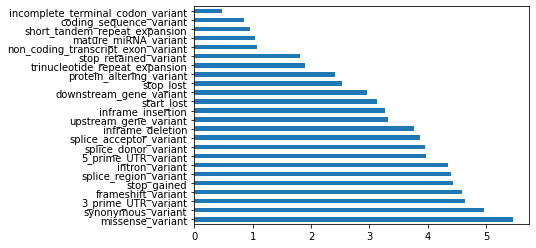

In [3]:
import math

eva_df.consequence.value_counts().apply(lambda x: math.log10(x)).plot(kind = 'barh')


In [38]:
eva_df.columns

Index(['type', 'target', 'disease', 'rsid', 'clinvar_acces', 'score', 'star',
       'review_status', 'clinical_significance', 'so_code', 'consequence'],
      dtype='object')

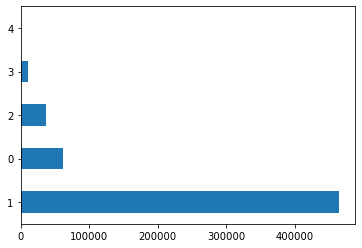

In [40]:
eva_df.star.value_counts().plot(kind = 'barh')

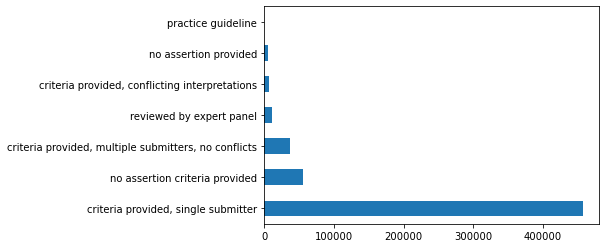

In [42]:
eva_df.review_status.value_counts().plot(kind = 'barh')

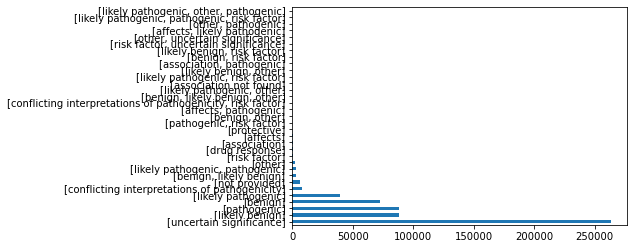

In [43]:
eva_df.clinical_significance.value_counts().plot(kind = 'barh')

In [49]:
eva_df.loc[ eva_df.clinical_significance.apply(lambda x: len(x) > 1) ]

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,consequence
1236,genetic_association,ENSG00000119899,Orphanet_309334,rs386833993,RCV000049970,1.000000e-07,2,"criteria provided, multiple submitters, no con...","[likely pathogenic, pathogenic]",SO_0001587,stop_gained
3046,genetic_association,ENSG00000026103,Orphanet_3261,rs1564696849,RCV000695507,1.000000e-07,2,"criteria provided, multiple submitters, no con...","[likely pathogenic, pathogenic]",SO_0001575,splice_donor_variant
3886,genetic_association,ENSG00000136160,Orphanet_897,rs768126403,RCV000721946,1.000000e-07,0,no assertion criteria provided,"[likely pathogenic, pathogenic]",SO_0001587,stop_gained
4137,genetic_association,ENSG00000137700,Orphanet_79259,rs121908978,RCV000007345,1.000000e-07,2,"criteria provided, multiple submitters, no con...","[likely pathogenic, pathogenic]",SO_0001583,missense_variant
4153,genetic_association,ENSG00000137700,Orphanet_79259,rs781784543,RCV000169082,1.000000e-07,2,"criteria provided, multiple submitters, no con...","[likely pathogenic, pathogenic]",SO_0001587,stop_gained
...,...,...,...,...,...,...,...,...,...,...,...
566079,genetic_association,ENSG00000138376,Orphanet_227535,rs150354152,RCV001086278,1.000000e-07,2,"criteria provided, multiple submitters, no con...","[benign, likely benign]",SO_0001819,synonymous_variant
566270,genetic_association,ENSG00000046604,Orphanet_247,rs370509593,RCV001087023,1.000000e-07,2,"criteria provided, multiple submitters, no con...","[benign, likely benign]",SO_0001583,missense_variant
566605,genetic_association,ENSG00000164190,Orphanet_199,rs142923613,RCV001088813,1.000000e-07,2,"criteria provided, multiple submitters, no con...","[benign, likely benign]",SO_0001583,missense_variant
570522,genetic_association,ENSG00000134571,EFO_0000318,rs397516083,RCV001170203,1.000000e-07,2,"criteria provided, multiple submitters, no con...","[likely pathogenic, pathogenic]",SO_0001627,intron_variant


In [4]:

def add_significnace(x):
    for y in x:
        clin_significance.add(y)
        
clin_significance = set()
eva_df.clinical_significance.apply(add_significnace)



0         None
1         None
2         None
3         None
4         None
          ... 
574092    None
574093    None
574094    None
574095    None
574096    None
Name: clinical_significance, Length: 574097, dtype: object

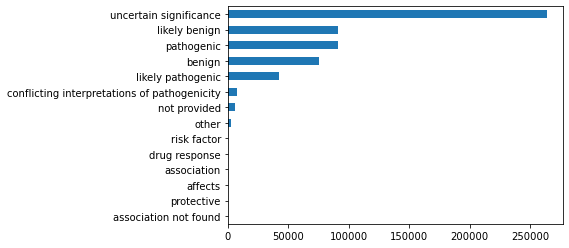

In [119]:
# clin_sign_counts = pd.Series(np.zeros(len(clin_significance)), index=clin_significance)

def add_count(x):
    for y in x:
        clin_sign_counts.loc[y] += 1 
        
# eva_df.clinical_significance.apply(add_count)
clin_sign_counts.sort_values().plot(kind = 'barh')

## Disease ontology lookup


For some region the disese labels are also not included in the evidence string. 

Generating from the full evidence file:

```bash
cat \
    <(echo -e "efo_id\tlabel" ) \
    <(gzcat 20.06_evidence_data.json.gz | jq -r '"\(.disease.id)\t\(.disease.efo_info.label)"' | sort -u ) \
    | gzip \
    > efo_id_map.tsv.gz
```

In [5]:
efo_map_df = pd.read_csv('efo_id_map.tsv.gz', sep='\t')
eva_df = eva_df.merge(efo_map_df, how='left', left_on='disease', right_on='efo_id')

## Gene symbol lookup

Gene symbols are also not included in the evidence string. 

```bash
cat \
    <(echo -e "gene_id\tsymbol" ) \
    <(gzcat 20.06_evidence_data.json.gz | jq -r '"\(.target.id)\t\(.target.gene_info.symbol)"' | sort -u ) \
    | gzip \
    > gene_id_map.tsv.gz
```

In [6]:
gene_id_map_df = pd.read_csv('gene_id_map.tsv.gz', sep='\t')
eva_df = eva_df.merge(gene_id_map_df, how='left', left_on='target', right_on='gene_id')

In [7]:
eva_df['clinical_significance'] = eva_df.clinical_significance.apply(lambda x: json.dumps(x))
eva_df.to_csv('updated_eva.tsv.gz', compression='infer', index=False, sep='\t')

In [83]:
# eva_df.drop(['gene_id', 'symbol'], axis =1 , inplace=True)
import requests

missing_gene_map = {}
for ensembl_id in eva_df.loc[eva_df.symbol.isna()].target.unique():
    r = requests.get(f'http://rest.ensembl.org/lookup/id/{ensembl_id}?content-type=application/json;expand=0')
    missing_gene_map[ensembl_id] = r.json()['display_name']

In [96]:
eva_df['symbol'] = eva_df.apply(lambda row: row['symbol'] if not isinstance(row['symbol'], float) else missing_gene_map[row['target']], axis=1)



In [91]:
?isinstance

In [103]:
missing_efo_map = {}
for efo_id in eva_df.loc[eva_df.label.isna()].disease.unique():
    url = f'https://www.ebi.ac.uk/ols/api/terms?short_form={efo_id}'
    r = requests.get(url)
    data = r.json()

    missing_efo_map[efo_id] = data['_embedded']['terms'][0]['label']


In [104]:
eva_df['label'] = eva_df.apply(lambda row: row['label'] if not isinstance(row['label'], float) else missing_efo_map[row['disease']], axis=1)


In [106]:
eva_df.loc[eva_df['symbol'].isna()]

,type,target,disease,rsid,clinvar_acces,score,star,review_status,clinical_significance,so_code,consequence,efo_id,label,gene_id,symbol
